In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from keras.utils.vis_utils import model_to_dot


import pydot

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import keras_tuner as kt

In [2]:
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10
TEST_SIZE = 0.2
RANDOM_STATE = 2023
#Model
NO_EPOCHS = 50
BATCH_SIZE = 128


Data Wrangling

In [3]:
train_data = pd.read_csv('fashion-mnist_train.csv')
test_data = pd.read_csv('fashion-mnist_test.csv')

In [4]:
train_data.shape

(60000, 785)

In [5]:
print("Fashion MNIST train has rows:",train_data.shape[0]," and columns:", train_data.shape[1])
print("Fashion MNIST test has rows:",test_data.shape[0]," and columns:", test_data.shape[1])

Fashion MNIST train has rows: 60000  and columns: 785
Fashion MNIST test has rows: 10000  and columns: 785


Preprossecing:

This code defines a function data_preprocessing that takes a raw dataset as input and performs the following steps:

Converts the labels to a one-hot encoded categorical matrix using np_utils.to_categorical.
Reshapes the feature array to match the image dimensions.
Normalizes the pixel values by dividing them by 255.
Returns the preprocessed input features and output labels.
The function is intended to be used for preparing image data for training a multi-class classification model.



In [9]:
from keras.utils import np_utils

# Data Preprocessing

# The function `data_preprocessing` takes a raw dataset as input and performs necessary preprocessing steps.

# Import the `np_utils` module from Keras. This module provides utility functions for data preprocessing,
# specifically for converting class vectors (labels) to categorical matrices.

def data_preprocessing(raw):
    # Convert labels to categorical matrices

    # The `to_categorical` function from `np_utils` converts the label column of the raw dataset into
    # a one-hot encoded categorical matrix. This is required for training a multi-class classification model.

    out_y = np_utils.to_categorical(raw.label, NUM_CLASSES)

    # Extract features and reshape

    # Get the number of images in the dataset
    num_images = raw.shape[0]

    # Extract the feature columns (pixel values) from the raw dataset
    x_as_array = raw.values[:,1:]

    # Reshape the feature array to match the image dimensions

    # The `reshape` function is used to reshape the feature array into a 4-dimensional array.
    # The new shape is specified as (num_images, IMG_ROWS, IMG_COLS, 1), where:
    # - num_images: Number of images in the dataset
    # - IMG_ROWS: Number of rows in each image
    # - IMG_COLS: Number of columns in each image
    # - 1: The channel dimension, which is 1 since the images are grayscale

    x_shaped_array = x_as_array.reshape(num_images, IMG_ROWS, IMG_COLS, 1)

    # Normalize the pixel values

    # Divide the reshaped array by 255 to normalize the pixel values between 0 and 1.
    # This is a common preprocessing step for image data.

    out_x = x_shaped_array / 255

    # Return the preprocessed input features (x) and output labels (y)

    return out_x, out_y


In [10]:
NUM_CLASSES = 10
X, y = data_preprocessing(train_data)
X_test, y_test = data_preprocessing(test_data)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2023)

In [14]:
print("Fashion MNIST train -  rows:",X_train.shape[0]," columns:", X_train.shape[1:4])
print("Fashion MNIST valid -  rows:",X_val.shape[0]," columns:", X_val.shape[1:4])
print("Fashion MNIST test -  rows:",X_test.shape[0]," columns:", X_test.shape[1:4])

Fashion MNIST train -  rows: 48000  columns: (28, 28, 1)
Fashion MNIST valid -  rows: 12000  columns: (28, 28, 1)
Fashion MNIST test -  rows: 10000  columns: (28, 28, 1)


Model:

This model defines a CNN model architecture using the Sequential API in Keras. Here's a breakdown of the model architecture and its components:

The model starts with a convolutional layer (Conv2D) with 32 filters, a kernel size of (3, 3), ReLU activation. The input shape of the layer is specified as (IMG_ROWS, IMG_COLS, 1), which represents the dimensions of the input images.

A max pooling layer (MaxPooling2D) with a pool size of (2, 2) is added after the first convolutional layer.

Another convolutional layer with 64 filters and a kernel size of (3, 3) is added.

Another max pooling layer with a pool size of (2, 2) is added.

A third convolutional layer with 128 filters and a kernel size of (3, 3) is added.

The output from the previous layer is flattened using the Flatten layer to convert it into a 1-dimensional tensor.

A dense (fully connected) layer with 128 units and ReLU activation is added.

The final dense layer is added with the number of units equal to NUM_CLASSES, which represents the number of classes in the classification task. The activation function used for this layer is softmax, which produces the class probabilities.

The model is compiled by specifying the loss function as categorical cross-entropy, the optimizer as Adam, and the evaluation metric as accuracy.

This model architecture follows a typical CNN structure with alternating convolutional and pooling layers, followed by fully connected layers for classification. The compile function prepares the model for training by configuring the necessary settings for optimization.




In [71]:
# Model Definition

# The following code defines a convolutional neural network (CNN) model using the Sequential API in Keras.

# Create a sequential model
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal',\
                 input_shape=(IMG_ROWS, IMG_COLS, 1), name='conv1'))

# Add a max pooling layer
model.add(MaxPooling2D((2, 2)))

# Add the second convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add the third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))

# Flatten the output from the previous layer
model.add(Flatten())

# Add a dense (fully connected) layer with 128 units and ReLU activation
model.add(Dense(128, activation='relu'))

# Add the final dense layer with the number of classes as units and softmax activation
model.add(Dense(NUM_CLASSES, activation='softmax'))

# Model Compilation

# Compile the model by specifying the loss function, optimizer, and evaluation metric(s)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [72]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 1152)             

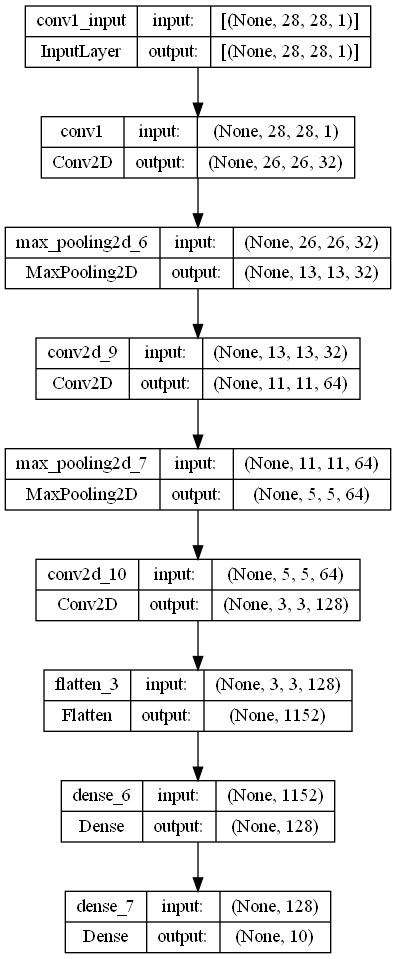

In [73]:
from tensorflow.keras.utils import plot_model

# Save the model architecture as a plot
plot_model(model, to_file='model_plot.png', show_shapes=True)

In [74]:
# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True)

# If the plot_model function does not work, you can try this alternative approach
# Create a graph from the model
dot = Digraph()

for i, layer in enumerate(model.layers):
    layer_name = f'layer_{i}'
    dot.node(layer_name, layer.name)
    
    if i > 0:
        dot.edge(f'layer_{i-1}', layer_name)
    
# Save the graph to a file
dot.render('model_graph', format='png')


'model_graph.png'

In [75]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/50
375/375 [==============================] - 13s 33ms/step - loss: 0.5334 - accuracy: 0.8067 - val_loss: 0.3746 - val_accuracy: 0.8611
Epoch 2/50
375/375 [==============================] - 12s 31ms/step - loss: 0.3436 - accuracy: 0.8759 - val_loss: 0.3119 - val_accuracy: 0.8839
Epoch 3/50
375/375 [==============================] - 14s 37ms/step - loss: 0.2882 - accuracy: 0.8964 - val_loss: 0.2880 - val_accuracy: 0.8977
Epoch 4/50
375/375 [==============================] - 13s 36ms/step - loss: 0.2553 - accuracy: 0.9073 - val_loss: 0.2846 - val_accuracy: 0.8938
Epoch 5/50
375/375 [==============================] - 13s 36ms/step - loss: 0.2300 - accuracy: 0.9158 - val_loss: 0.2683 - val_accuracy: 0.9023
Epoch 6/50
375/375 [==============================] - 13s 34ms/step - loss: 0.2079 - accuracy: 0.9228 - val_loss: 0.2730 - val_accuracy: 0.9040
Epoch 7/50
375/375 [==============================] - 12s 32ms/step - loss: 0.1863 - accuracy: 0.9320 - val_loss: 0.2789 - val_accuracy:

In [83]:
def plot_accuracy_and_loss(history):
    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.savefig("accuracy.png")
    plt.show()

    # Plot training and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.savefig("loss.png")
    plt.show()

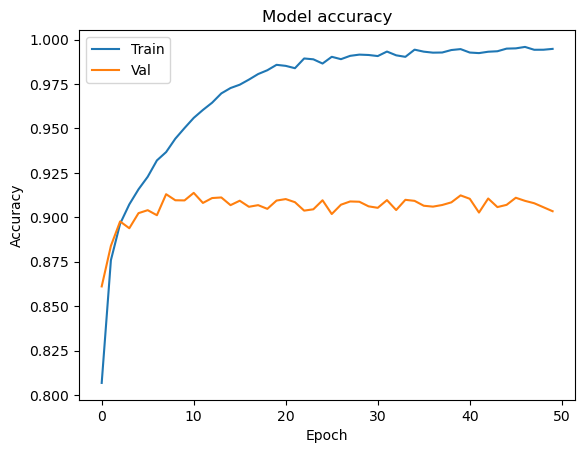

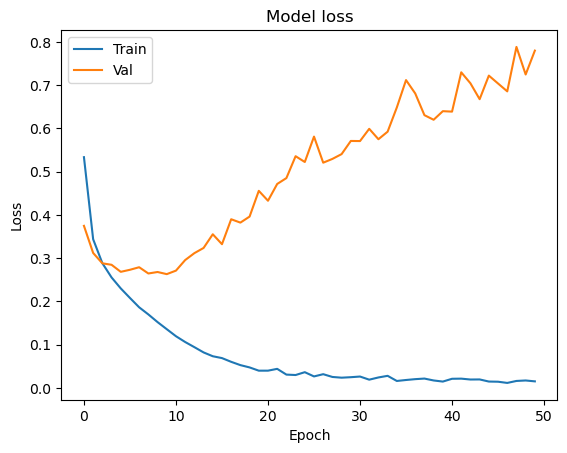

In [84]:
plot_accuracy_and_loss(train_model)

Adding dropout layers to the model is a technique used to mitigate overfitting in neural networks. Overfitting occurs when a model performs well on the training data but fails to generalize well to unseen data, such as the validation set.

By adding dropout layers, we introduce a form of regularization to the model. During training, dropout randomly sets a fraction of the input units to 0 at each update. This effectively forces the model to learn redundant representations and prevents it from relying too heavily on specific features or correlations present in the training data. Dropout acts as a form of ensemble learning, where multiple subnetworks with different sets of dropped-out units contribute to making predictions.

The purpose of dropout is to encourage the model to learn more robust and generalized representations that are less sensitive to noise and specific training samples. By randomly dropping units during training, dropout helps reduce the model's reliance on any individual feature or combination of features, making it more resilient to overfitting.

Adding dropout layers may help improve its performance on the validation set by reducing overfitting. By preventing the model from becoming overly complex and too specialized to the training data, dropout can promote better generalization and enhance the model's ability to make accurate predictions on unseen data.

In [85]:
# Model
model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',\
                 input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(MaxPooling2D((2, 2)))
# Add dropouts to the model
model.add(Dropout(0.25))
# Add another convolution 2D layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropouts to the model
model.add(Dropout(0.25))
# Add another convolution 2D layer
model.add(Conv2D(128, (3, 3), activation='relu'))
# Add dropouts to the model
model.add(Dropout(0.4))
# Flatten the output from the previous layer
model.add(Flatten())
# Add a dense layer with ReLU activation
model.add(Dense(128, activation='relu'))
# Add dropouts to the model
model.add(Dropout(0.3))
# Add the final dense layer with softmax activation for classification
model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile the model with specified loss function, optimizer, and metrics
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])


In this code, dropout layers have been added to the model. Dropout is a regularization technique that helps prevent overfitting in neural networks. It works by randomly setting a fraction of input units to 0 during training, which helps to prevent the model from relying too much on specific features and encourages it to learn more robust and generalizable representations.

In this specific model, dropout layers with different dropout rates have been added after each pooling layer and after the dense layer. The dropout rates used are 0.25, 0.4, and 0.3. These rates determine the fraction of input units to drop during training. By adding dropout, the model aims to improve its generalization performance and reduce overfitting on the training data, thus improving its performance on the validation set.

In [86]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 module_wrapper_4 (ModuleWra  (None, 13, 13, 32)       0         
 pper)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                      

In [87]:

# Plot the model
plot_model(model, to_file='model_plot_modified.png', show_shapes=True)

# If the plot_model function does not work, you can try this alternative approach
# Create a graph from the model
dot = Digraph()

for i, layer in enumerate(model.layers):
    layer_name = f'layer_{i}'
    dot.node(layer_name, layer.name)
    
    if i > 0:
        dot.edge(f'layer_{i-1}', layer_name)
    
# Save the graph to a file
dot.render('model_graph_modified', format='png')


'model_graph_modified.png'

In [88]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/50
375/375 [==============================] - 17s 42ms/step - loss: 0.7519 - accuracy: 0.7182 - val_loss: 0.4493 - val_accuracy: 0.8382
Epoch 2/50
375/375 [==============================] - 14s 38ms/step - loss: 0.4695 - accuracy: 0.8291 - val_loss: 0.3574 - val_accuracy: 0.8656
Epoch 3/50
375/375 [==============================] - 15s 39ms/step - loss: 0.4067 - accuracy: 0.8497 - val_loss: 0.3160 - val_accuracy: 0.8808
Epoch 4/50
375/375 [==============================] - 14s 38ms/step - loss: 0.3691 - accuracy: 0.8654 - val_loss: 0.3021 - val_accuracy: 0.8888
Epoch 5/50
375/375 [==============================] - 14s 37ms/step - loss: 0.3445 - accuracy: 0.8731 - val_loss: 0.2862 - val_accuracy: 0.8947
Epoch 6/50
375/375 [==============================] - 14s 37ms/step - loss: 0.3254 - accuracy: 0.8819 - val_loss: 0.2710 - val_accuracy: 0.8990
Epoch 7/50
375/375 [==============================] - 15s 39ms/step - loss: 0.3134 - accuracy: 0.8859 - val_loss: 0.2662 - val_accuracy:

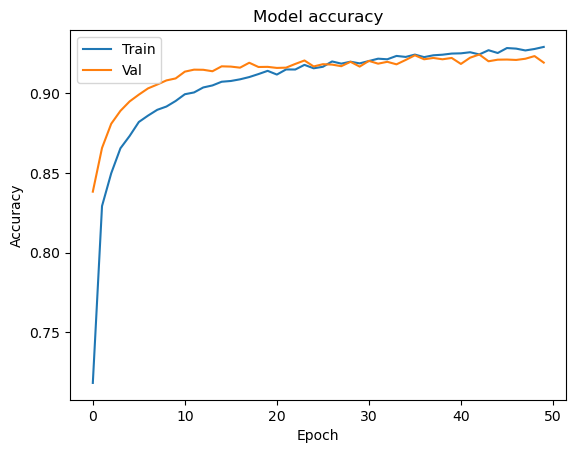

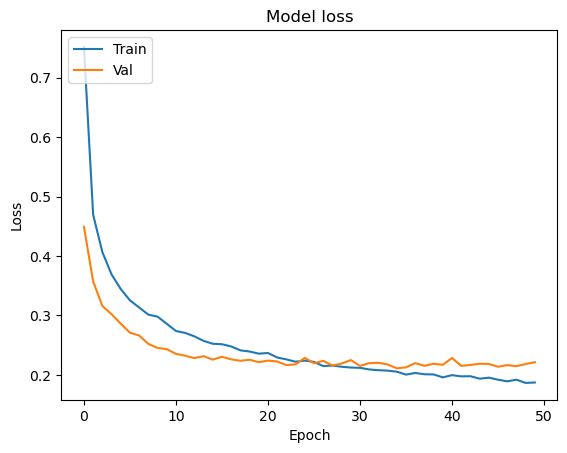

In [89]:
plot_accuracy_and_loss(train_model)

In [90]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.2089 - accuracy: 0.9258
Test loss: 0.20888298749923706
Test accuracy: 0.9258000254631042


In [91]:
# get the predictions for the test data
predicted_probabilities = model.predict(X_test)
predicted_classes = predicted_probabilities.argmax(axis=1)

# get the indices to be plotted
y_true = test_data.iloc[:, 0].to_numpy() 

313/313 [==============================] - 1s 4ms/step


In [92]:
len(predicted_classes)

10000

In [93]:
p = predicted_classes[:10000]
y = y_true[:10000]
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

In [94]:
print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 9258
Incorrect predicted classes: 742


In [95]:
#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_true, predicted_classes)
#plt.figure(figsize = (14,10))
#sns.heatmap(cm, annot=True)

In [99]:
#cm = confusion_matrix(y_true, predicted_classes)

#plt.figure(figsize=(14, 10))
#sns.heatmap(cm, annot=True, cmap="Blues")

# Set x-axis and y-axis labels using class labels
#tick_labels = [labels[i] for i in range(len(labels))]
#plt.xticks(np.arange(len(labels)), tick_labels, rotation=45)
#plt.yticks(np.arange(len(labels)), tick_labels, rotation=0)

#plt.xlabel('Predicted Classes')
#plt.ylabel('True Classes')
#plt.title('Confusion Matrix')

# Save the plot
#plt.savefig('confusion_matrix.png')

#plt.show()

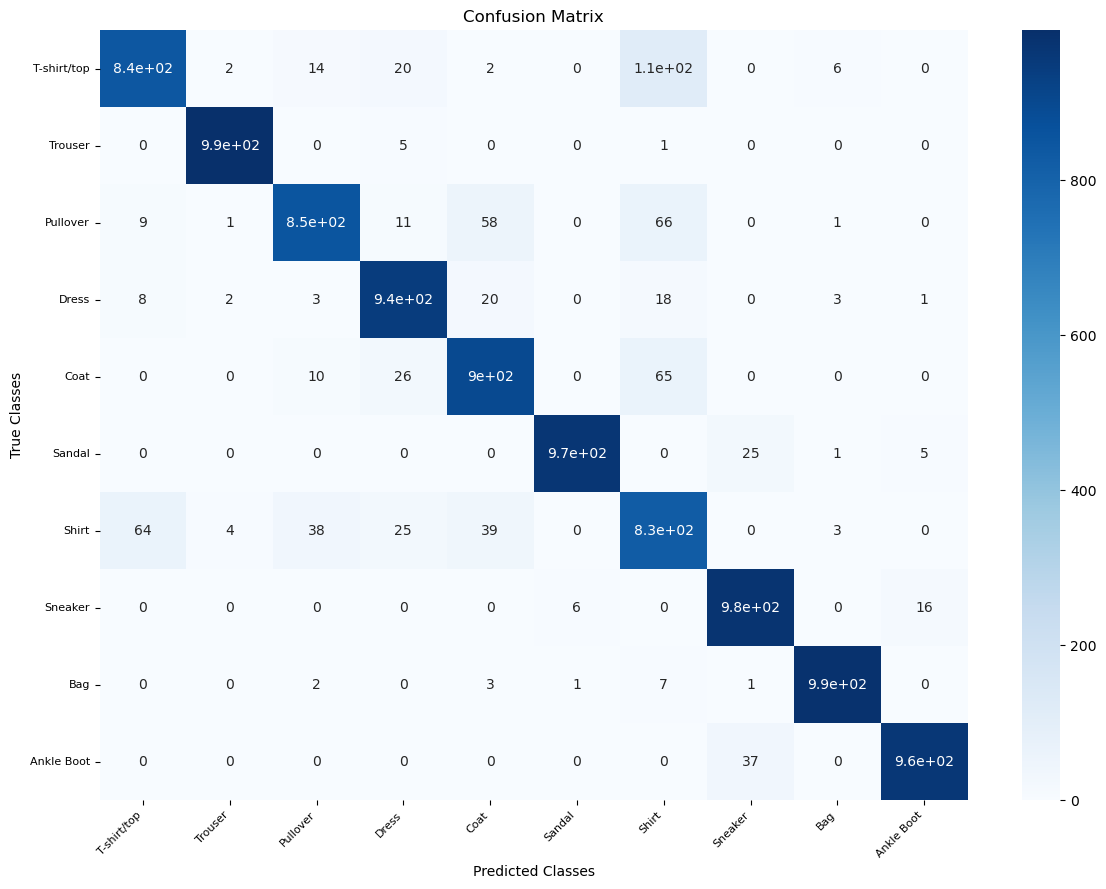

In [98]:
cm = confusion_matrix(y_true, predicted_classes)

plt.figure(figsize=(14, 10))
heatmap = sns.heatmap(cm, annot=True, cmap="Blues")

# Set x-axis and y-axis labels using class labels
tick_labels = [labels[i] for i in range(len(labels))]
heatmap.set_xticks(np.arange(len(labels)) + 0.5, minor=False)
heatmap.set_yticks(np.arange(len(labels)) + 0.5, minor=False)
heatmap.set_xticklabels(tick_labels, rotation=45, ha="right", fontsize=8)
heatmap.set_yticklabels(tick_labels, rotation=0, ha="right", fontsize=8)

plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix')

# Save the plot
plt.savefig('confusion_matrix.png')

plt.show()

In [101]:
target_names = ["Class {} ({}) :".format(i,labels[i]) for i in range(NUM_CLASSES)]

# Generate classification report
report = classification_report(y_true, predicted_classes, target_names=target_names)

# Print the classification report
print(report)

                         precision    recall  f1-score   support

Class 0 (T-shirt/top) :       0.91      0.84      0.88      1000
    Class 1 (Trouser) :       0.99      0.99      0.99      1000
   Class 2 (Pullover) :       0.93      0.85      0.89      1000
      Class 3 (Dress) :       0.92      0.94      0.93      1000
       Class 4 (Coat) :       0.88      0.90      0.89      1000
     Class 5 (Sandal) :       0.99      0.97      0.98      1000
      Class 6 (Shirt) :       0.75      0.83      0.79      1000
    Class 7 (Sneaker) :       0.94      0.98      0.96      1000
        Class 8 (Bag) :       0.99      0.99      0.99      1000
 Class 9 (Ankle Boot) :       0.98      0.96      0.97      1000

               accuracy                           0.93     10000
              macro avg       0.93      0.93      0.93     10000
           weighted avg       0.93      0.93      0.93     10000



The classification report provides a comprehensive evaluation of the performance of a multi-class classification model. It includes several metrics such as precision, recall, and F1-score, which assess the model's accuracy, completeness, and balance in predicting each class. Here's an explanation of the metrics and the overall report:

Precision: It measures the proportion of correctly predicted instances for a particular class out of all instances predicted as that class. A high precision indicates a low false positive rate, meaning the model makes fewer incorrect predictions for that class.

Recall: Also known as the true positive rate or sensitivity, it measures the proportion of correctly predicted instances for a particular class out of all instances belonging to that class. A high recall indicates a low false negative rate, meaning the model captures a larger proportion of instances of that class.

F1-score: It is the harmonic mean of precision and recall, providing a balanced measure that considers both metrics. It is particularly useful when classes have imbalanced distributions. A high F1-score indicates a good balance between precision and recall.

Support: It represents the number of instances in each class in the dataset.

The classification report provides these metrics for each class individually, as well as the average values across all classes. Additionally, it reports the overall accuracy, which represents the proportion of correctly predicted instances across all classes.

In this classification report, each class is labeled with its corresponding name and index. The precision, recall, and F1-score for each class indicate how well the model performs in predicting that particular class. The accuracy of 0.93 suggests that the model achieves a high overall classification accuracy on the given dataset.

The macro average and weighted average values provide a summary of the performance across all classes. The macro average calculates the metrics independently for each class and then takes the average, giving equal weight to each class. The weighted average takes into account the support (number of instances) for each class, providing a weighted average based on the class distribution.

Overall, this classification report gives you insights into the performance of the model for each class and allows to identify classes where the model performs well or needs improvement.





In [105]:
def plot_images(data_index,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(4,4, figsize=(15,15))

    for i, indx in enumerate(data_index[:16]):
        ax[i//4, i%4].imshow(X_test[indx].reshape(IMG_ROWS,IMG_COLS), cmap=cmap)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title("True:{}  Pred:{}".format(labels[y_true[indx]],labels[predicted_classes[indx]]))
        plt.savefig('sample_images.png')  # Save the figure
    plt.show()    
    



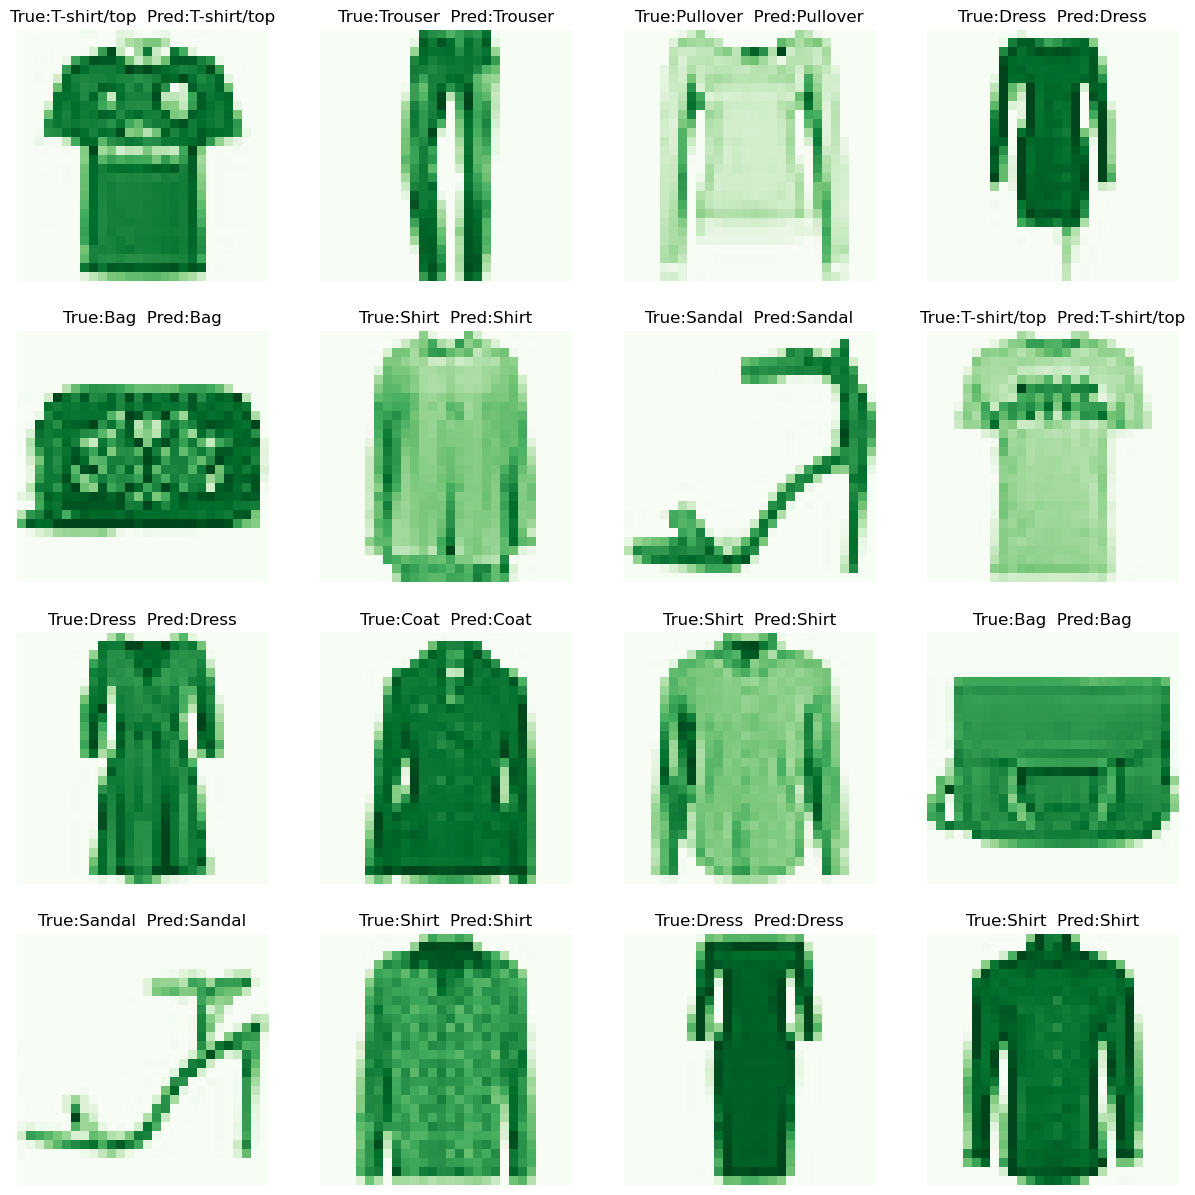

In [107]:
plot_images(correct, "Greens")

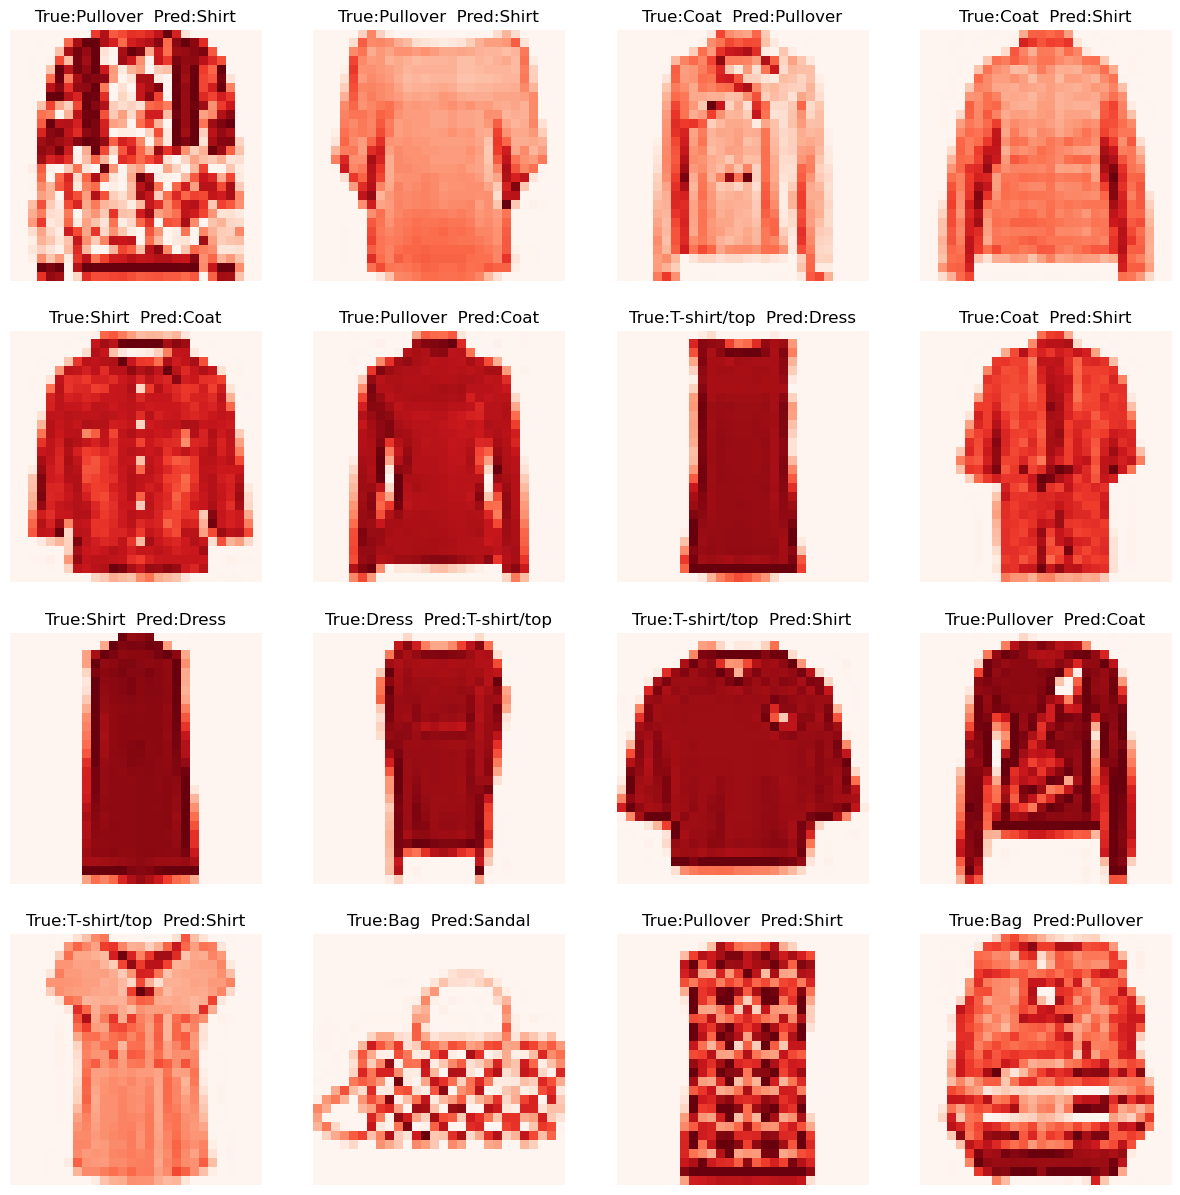

In [106]:
plot_images(incorrect, "Reds")

Limitations:

Limited Dataset: The fashion MNIST dataset consists of 60,000 training images and 10,000 test images. While this dataset is suitable for initial experimentation, it may not fully capture the wide variety of real-world clothing items. Consider exploring larger and more diverse datasets for improved generalization.

Class Imbalance: The fashion MNIST dataset has an equal distribution of samples across all classes. However, in real-world scenarios, the distribution of clothing items may not be balanced. It is important to address class imbalance issues by applying appropriate data augmentation techniques or utilizing advanced algorithms such as oversampling or undersampling.

Lack of Spatial Context: The fashion MNIST dataset only provides grayscale images of clothing items. This limits the ability of the model to capture spatial features and patterns that may be present in color images. Extending the model to handle RGB color images or exploring alternative datasets with color information could improve performance.

Future Work:

Fine-tuning: Experiment with fine-tuning the model architecture or hyperparameters to further improve performance. This could involve adjusting the number and size of convolutional layers, exploring different activation functions, or using advanced optimization techniques.

Transfer Learning: Consider leveraging pre-trained models, such as those trained on larger datasets like ImageNet, and adapting them to the fashion MNIST task. Transfer learning can help benefit from the knowledge learned on a larger dataset and potentially boost the model's performance.

Model Interpretability: Investigate techniques for interpreting the model's decisions and understanding its internal representations. This could involve visualizing learned filters, conducting feature importance analysis, or using techniques like Grad-CAM to highlight important regions in the images that contribute to the predictions.

Ensemble Methods: Explore ensemble methods by combining multiple models to improve the overall prediction accuracy. This can be done by training different variations of the model with different initializations, architectures, or hyperparameters, and then combining their predictions to make the final decision.

Deployment and Optimization: Once you have a satisfactory model, consider optimizing it for deployment on resource-constrained environments. Techniques like model quantization, pruning, or using lightweight architectures can help reduce the model size and computational requirements while maintaining acceptable performance.